# Flat Pipeline

In [1]:
import sys

from pyspark.sql import functions as F
from pyspark.sql.types import *

import yaml

from nlsn.nebula.spark_transformers import *
from nlsn.nebula.base import Transformer
from nlsn.nebula.pipelines.pipelines import TransformerPipeline
from nlsn.nebula.pipelines.pipeline_loader import load_pipeline
from nlsn.nebula.storage import nebula_storage as ns

py_version = ".".join(map(str, (sys.version_info[0:2])))
print("python version:", py_version)

python version: 3.7


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [ ]:
schema = [
    StructField("c1", FloatType(), True),
    StructField("c2", StringType(), True),
    StructField("c3", StringType(), True),
]

data = [
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [1.1234, "a", "  b"],
    [2.1234, "  a  ", "  b  "],
    [3.1234, "", ""],
    [4.1234, "   ", "   "],
    [5.1234, None, None],
    [6.1234, " ", None],
    [7.1234, "", None],
    [8.1234, "a", None],
    [9.1234, "a", ""],
    [10.1234, "   ", "b"],
    [11.1234, "a", None],
    [12.1234, None, "b"],
    [13.1234, None, "b"],
    [14.1234, None, None],
]

df_input = spark.createDataFrame(data, schema=StructType(schema)).cache()
df_input.show()

## Create a pipeline using python

3 transformers:

- EmptyStringToNull
- Distinct
- CoalescePartitions

To show the pipeline steps without actually running it, call the method `show_pipeline`.

In [3]:
# from nlsn.nebula.spark_pipelines.pipelines import TransformerPipeline
pipe = TransformerPipeline([
    EmptyStringToNull(columns=["c2", "c3"]),
    Distinct(),
    CoalescePartitions(num_partitions=5)
])

pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline *** (3 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
 - Distinct
 - CoalescePartitions -> PARAMS: num_partitions=5


### If graphviz is installed

https://graphviz.org/download/

To render the the pipeline, call the method `plot_dag`.<br>
If your `Python` version is less than 3.8, there might be some visualization issues.

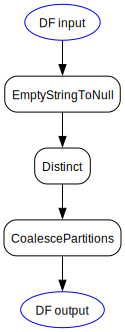

In [4]:
pipe.plot_dag()

To add the transformer parameters, simply set `add_transformer_params=True` in the `show_pipeline` method as follows:

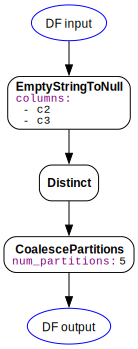

In [5]:
pipe.plot_dag(add_transformer_params=True)

In [7]:
pipe.render_html()

## Actual run

In [ ]:
df_out = pipe.run(df_input)
df_out.show()

## Create the same pipeline using yaml

In [8]:
yml_data = """
pipeline:
  - transformer: EmptyStringToNull
    params:
      columns: ["c2", "c3"]
  - transformer: Distinct
  - transformer: CoalescePartitions
    params:
        num_partitions: 5
"""

pipe_cfg = yaml.safe_load(yml_data)

# from nlsn.nebula.spark_pipelines.pipeline_loader import load_pipeline
pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline *** (3 transformers)
 - EmptyStringToNull -> PARAMS: columns=['c2', 'c3']
 - Distinct
 - CoalescePartitions -> PARAMS: num_partitions=5


In [ ]:
pipe.run(df_input).show()